# Import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Set today date and read data

In [2]:
today = '2021-07-08'
today_str = '8th July'

In [3]:
data = pd.read_csv(f'cumulative-doses-data/doses-{today}.csv')
print(data.shape)

(96591, 13)


In [4]:
data.head()

id  state_id  male_doses  female_doses  today_male  today_female  \
0  581         3       79492         61233           0             0   
1  582        13      518419        552011           0             0   
2  583        13      188658        181561           0             0   
3  584        17     2799186       3368802       76059         81868   
4  585        20     3671408       3199738           0             0   

   today_doses        date  district_id  others_doses  today_others  \
0       7221.0  2021-04-19          NaN            69           NaN   
1      33793.0  2021-04-15          NaN           148           NaN   
2      37996.0  2021-03-25          NaN            41           NaN   
3     157961.0  2021-05-07          NaN           792          33.0   
4      28170.0  2021-04-23          NaN           816           NaN   

   difference_today  difference_total  
0                 0            -18259  
1                 0             33592  
2                 0             -7097  
3              5809            569616  
4                 0           -471670

## Retrieve IDs for states, districts for lookups

In [5]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///vaccines.db', echo=False)


def get_identifiers():
    df = pd.read_sql_table('identifiers', con=engine)
    return df


In [6]:
ids = get_identifiers()
states = ids[['state_id', 'state_name']].drop_duplicates()
districts = ids[['district_id', 'district_name']].drop_duplicates()

### Create state_name column for human readability

In [7]:
fillna_cols = ['today_male', 'today_female', 'today_doses', 'male_doses',
               'female_doses', 'others_doses', 'today_others']

for col in fillna_cols:
    data[col].fillna(0, inplace=True)

data['state_name'] = data['state_id'].apply(
    lambda x: states[states['state_id'] == x].state_name.values[0])

### Derive new columns 

- total doses: sum of doses given to male and female
- programming friendly date column
- daily ratio (male/female) of doses
- daily and total difference in doses administered to female and male

In [8]:
data['total_doses'] = data['male_doses'] + data['female_doses']

data['_date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['daily_ratio'] = data['male_doses'] / data['female_doses']
data['difference_total'] = data['female_doses'] - data['male_doses']
data['difference_today'] = data['today_female'] - data['today_male']

## State-wise small multiples of total doses difference between women and men

/home/bhanu/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


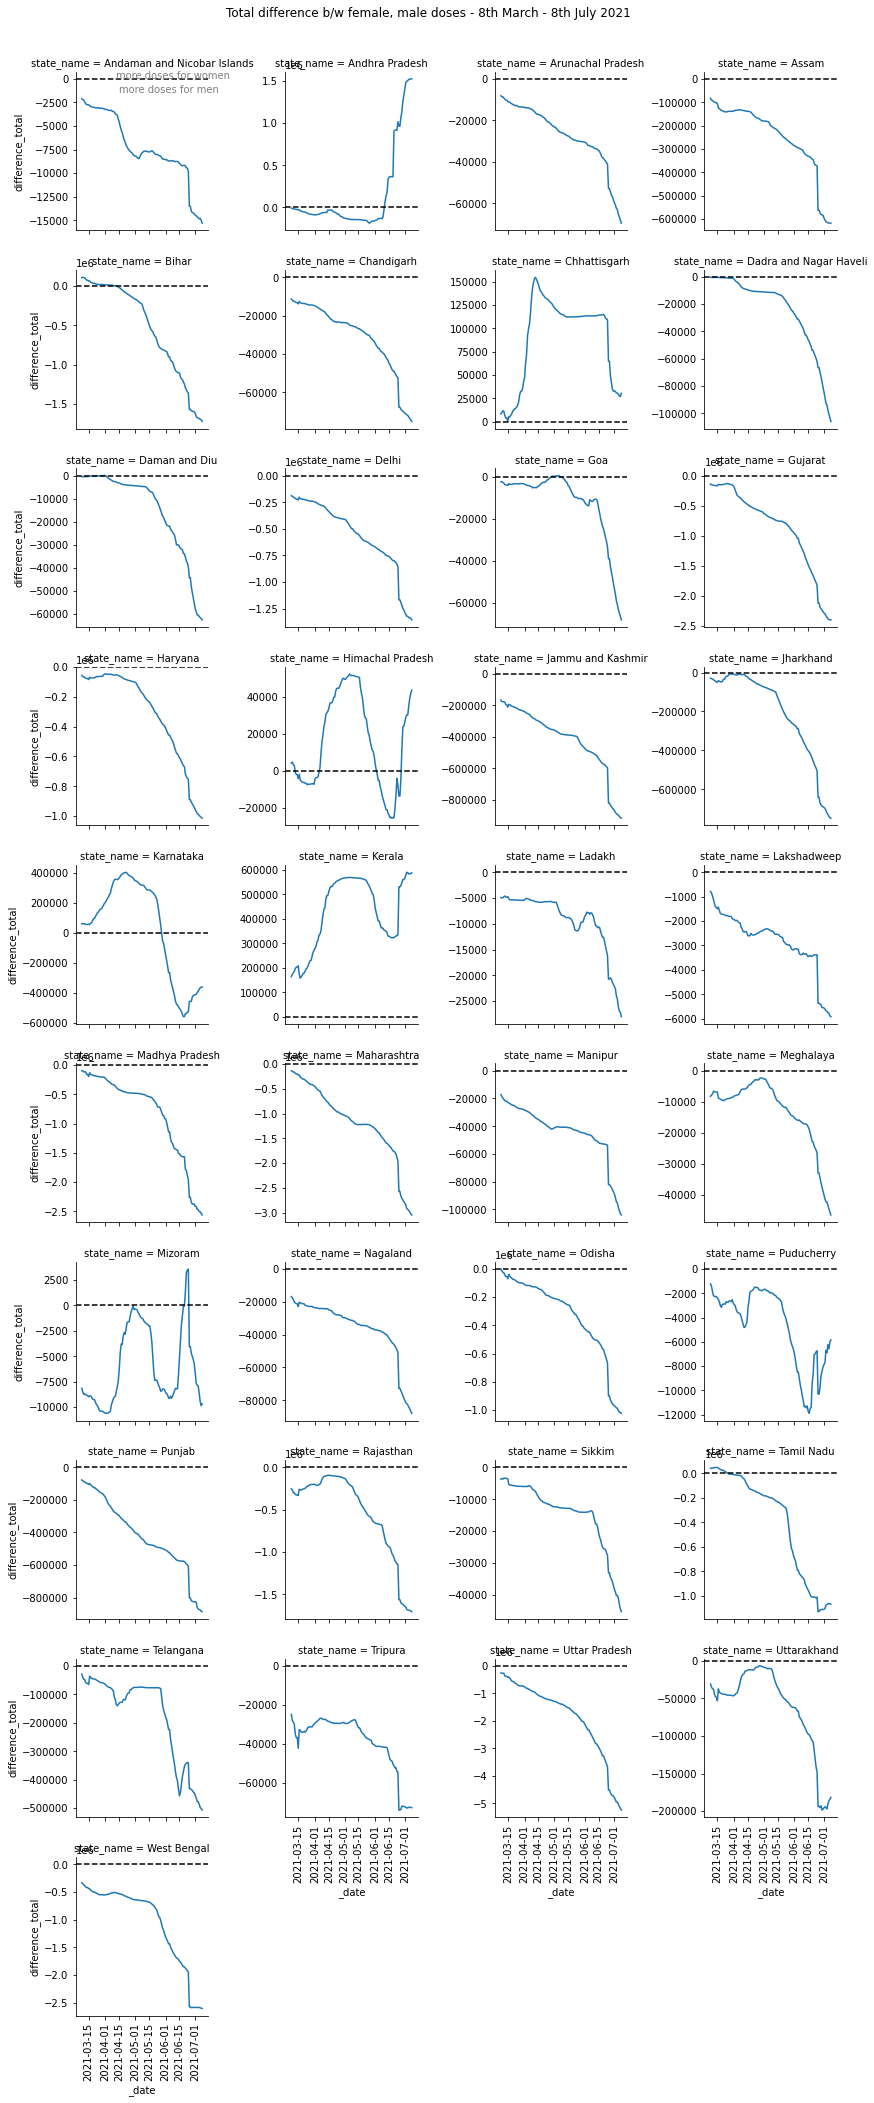

In [9]:
import numpy as np

g = sns.FacetGrid(
    data[(data['district_id'].isna())].sort_values(by='state_name'),
    col="state_name", sharey=False, col_wrap=4)

g.map(sns.lineplot, "_date", "difference_total")
g.set_xticklabels(rotation=90)

for axes in g.axes:
    axes.axhline(0, ls='--', c='black')

g.axes[0].text('2021-04-12', 50, 'more doses for women', color='gray')
g.axes[0].text('2021-04-15', -1500, 'more doses for men', color='gray')

g.fig.suptitle(f'Total difference b/w female, male doses - 8th March - {today_str} 2021')
g.fig.subplots_adjust(top=.95, bottom=0.05)
plt.savefig(f'difference-total-{today}.pdf')


## State-wise small multiples of daily doses difference between women and men

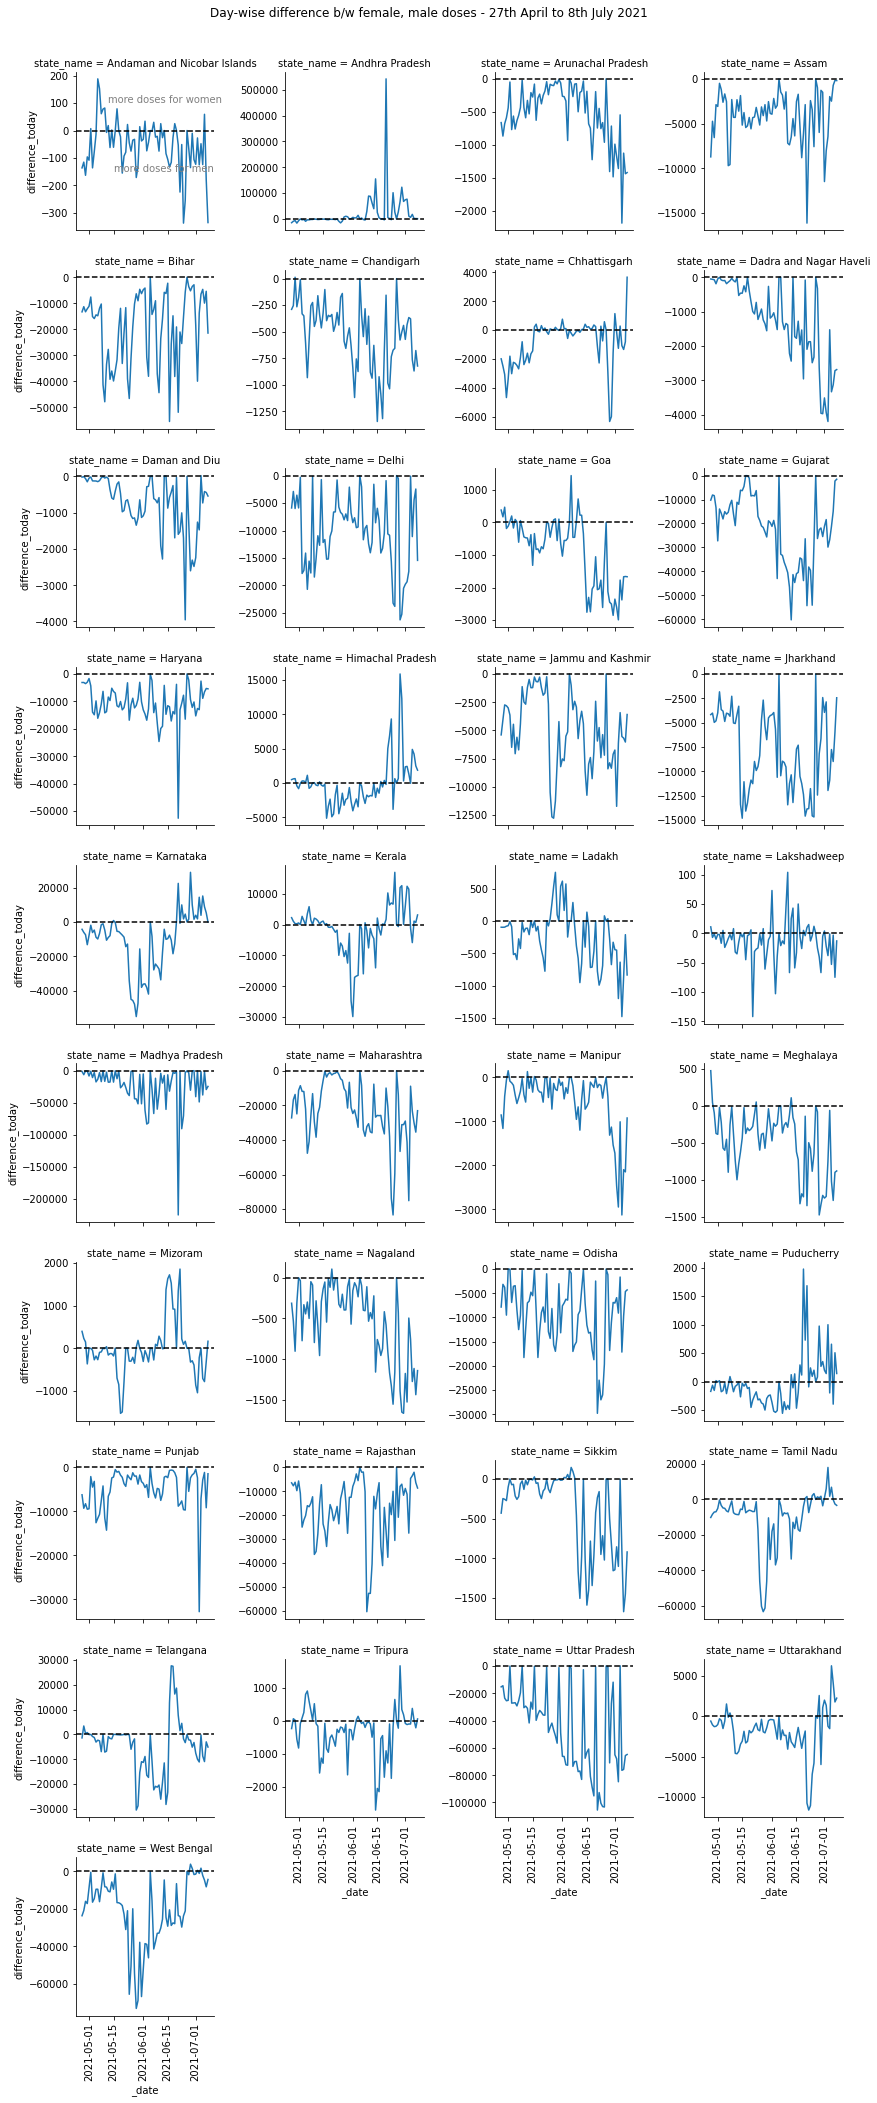

In [10]:
g = sns.FacetGrid(
    data[(data['_date'] > '2021-04-26') & (data['district_id'].isna())].sort_values(by='state_name'),
    col="state_name", sharey=False, col_wrap=4)

g.map(sns.lineplot, "_date", "difference_today")
g.set_xticklabels(rotation=90)

for axes in g.axes:
    axes.axhline(0, ls='--', c='black')

g.axes[0].text('2021-05-12', 100, 'more doses for women', color='gray')
g.axes[0].text('2021-05-15', -150, 'more doses for men', color='gray')

g.fig.suptitle(f'Day-wise difference b/w female, male doses - 27th April to {today_str} 2021')
g.fig.subplots_adjust(top=.95, bottom=0.05)
plt.savefig(f'difference-{today}.pdf')

### Lookup district name

In [11]:
data['district_id'].fillna(0, inplace=True)

In [12]:
data['district_name'] = data['district_id'].apply(
    lambda x: districts[districts['district_id'] == x].district_name.values[0] if 
        districts[districts['district_id'] == x].district_name.size > 0 else '-1')

In [13]:
today_data = data[data['date'] == today]

In [14]:
today_data['district_name'] = today_data['district_id'].apply(
    lambda x: districts[districts['district_id'] == x].district_name.values[0] if 
        districts[districts['district_id'] == x].district_name.size > 0 else '-1')

/home/bhanu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
data.shape, today, today_data.shape, data[data['_date'] == today].shape

((96591, 18), '2021-07-08', (791, 18), (791, 18))

## Write to file

Save district-wise dose differences to file

In [16]:
import openpyxl as pxl

f_out = f'state-districts-doses-{today}.xlsx'

notes = {
    'column': ['state_id', 'state_name', 'district_id', 'district_name', 'difference_today', 'difference_total'],
    'description': [
        'State identifier',
        'State name',
        'District identifier',
        'District name',
        f'difference in (women-men) doses on {today_str}',
        f'difference in (women-men) doses from 8th March to {today_str}'
    ]
}
notes = pd.DataFrame(notes)
notes.to_excel(f_out, 'notes', index=False)

excel_book = pxl.load_workbook(f_out)

In [17]:
state_cols = ['state_id', 'state_name', 'district_id', 'district_name', 'difference_today', 'difference_total']

for state_id in range(1, 38):
    state_data = today_data[today_data['state_id'] == state_id]
    df_view = state_data[state_data['district_id'] != '-1'][state_cols].sort_values(by='difference_total')

    with pd.ExcelWriter(f_out, engine='openpyxl') as writer:
        writer.book = excel_book
        df_view.to_excel(writer, sheet_name=f'{df_view["state_name"].values[0]}', index=False)

/home/bhanu/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
